The objective of the project is to classify healthy individuals from people affected by schizophrenia. 
We have 86 functional connectomes from 86 subjects. Among them, 46 are from healthy controls and 40 are from schizophrenic individuals.

In [1]:
#!pip install geomstats
import numpy as np
import matplotlib.pyplot as plt
import geomstats.datasets.utils as data_utils

data, _, labels= data_utils.load_connectomes()
print(f"There are {len(data)} connectomes:"
      f"{sum(labels==0)} healthy controls and {sum(labels==1)} schizoprenic patients.")

INFO: Note: NumExpr detected 14 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


There are 86 connectomes:46 healthy controls and 40 schizoprenic patients.


The brains have been divided in 28 areas. To quantify the distance between two connectomes, each connectome can be represented as a correlation matrix, which is a Symmetric Positve Definite (SPD) matrix. A common way to compare SPD matrices is the "manifold" of SPD matrices: we compute their distance from each other on the manifold. In this case the connectomes are 28 x 28 matrices.

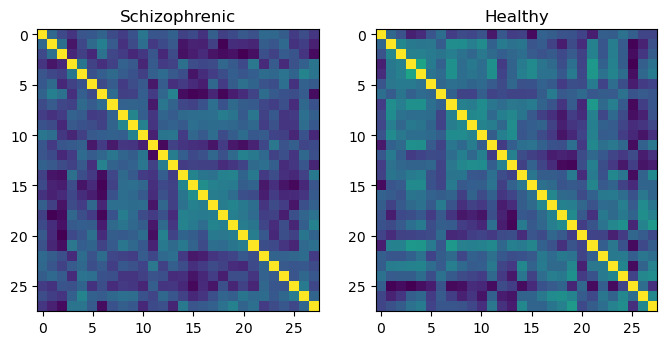

In [3]:
#Inspect the data: plotting the first two connectors
labels_str =["Healthy","Schizophrenic"]

fig= plt.figure(figsize=(8,4))

ax=fig.add_subplot(121)
imgplot=ax.imshow(data[0]);ax.set_title(labels_str[labels[0]])
ax=fig.add_subplot(122)
imgplot=ax.imshow(data[1]);ax.set_title(labels_str[labels[1]])

plt.show()

Each entry in these graphs represent a connection between two brain regions. The darkness of the square represents the strenght of the connection between the brain regions. The diagonal is the connection between each brain region with itself.
We want to verify that the Connectomes in the dataset actually belong to the Manifold of SPD (Symmetric Positive Definite) Matrices.

In [5]:
from geomstats.geometry.spd_matrices import SPDMatrices

spd_manifold =SPDMatrices (n=28, equip=True) #create the manifold object
spd_manifold.belongs(data) #checks if the data fall on the manifold

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

For the classification, we use the Riemannian Minimum Distance to Mean Classifier. In the training phase we compute the mean of each class and in the testing phase we give the label to the class whose mean is the closest to the new data point.

In [7]:
#Create our Classifier object
from geomstats.learning.mdm import RiemannianMinimumDistanceToMean

#define the mdm model
mdm=RiemannianMinimumDistanceToMean(space=spd_manifold)
mdm.classes_=2

In [9]:
#we split the dataset into a train and a test set
from sklearn.model_selection import train_test_split

X=data;y=labels
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=47)

print(f"The dataset has {len(X)} connectomes.")
print(f"The train set has {len(X_train)} connectomes and has size {X_train.shape}.")
print(f"The test set has {len(X_test)} connectomes and has size {X_test.shape}.")

The dataset has 86 connectomes.
The train set has 64 connectomes and has size (64, 28, 28).
The test set has 22 connectomes and has size (22, 28, 28).


In [11]:
# we train the model mdm to know the Frechet means of each class (two classes)
mdm.fit(X_train,y_train)

RiemannianMinimumDistanceToMean(space=<geomstats.geometry.spd_matrices.SPDMatrices object at 0x000001E8878EDC10>)

In [13]:
#we test, evaluating how well the trained model can predict schizophrenia on data never seen before
mdm.score(X_test,y_test)

0.7272727272727273

What if we computed everything using Euclidean Distance? 

In [15]:
#we test it using sklearn NearestCentroid Algorithm 
#so we reshape each connectome to be a 1D array instead of a 2D array

X_train=np.array(X_train.reshape(len(X_train),-1))
X_test=np.array(X_test.reshape(len(X_test),-1))

print(f"The train set has {len(X_train)} connectomes and has size {X_train.shape}.")
print(f"The test set has {len(X_test)} connectomes and has size {X_test.shape}.")               

The train set has 64 connectomes and has size (64, 784).
The test set has 22 connectomes and has size (22, 784).


In [17]:
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid(metric="euclidean")
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

C:\Users\AGuarino\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\AGuarino\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\AGuarino\AppData\Local\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\AGuarino\AppData\Local\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\AGuarino\AppData\Local\anaconda3\Lib\

0.6818181818181818

We see that geometry provides a prediction advantage (0.727 vs 0.681)

Now we try to train a Graph Neural network (GNN) on the same data and see how it performs. To do this, we need first to convert our functional connectivity matrices into a format more suitable for graph processing.

In [19]:
#! pip install torch 
#! pip install torch_geometric
import torch # import from pytorch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [35]:
#Convert our data into torch tensors
connectivity_matrices= torch.tensor(data).float()
labels=torch.tensor(labels).float()

#Create graph data objects for each matrix
data_list=[] #list of the connectivity matrices, one for each patient
for i in range(len(connectivity_matrices)):
    matrix=connectivity_matrices[i]
    edge_index=(matrix>0).nonzero(as_tuple=False).t() #creates edges based on non-zero entries
    edge_attr=matrix[edge_index[0],edge_index[1]] #edge weights are the matrix values
    x=torch.eye(28) #node features (identity matrix used as a sort of one hot encoding as features)

    #Create graph data object
    #x are the node features of the graph, feautures associated with each node (brain region) in the graph
    #edge_index defines the connections between nodes, represented as pair of indices
    #edge_attr are the attributes or weights associated with each edge (strenght of connectivity between nodes). These are the values from the connectivity matrix
    #y labels used for classification (healthy or schizophrenic)
    graph_data=Data(x=x,edge_index=edge_index,edge_attr=edge_attr,y=labels[i].unsqueeze(0))
    data_list.append(graph_data) 


torch.manual_seed(192024)

#Applying a 80:20 train test split (80% of data go into train set and 20% in test set)
split_index= int(len(data_list)*0.8)

#Manually split the data_list into train and test sets
train_data=data_list[:split_index]
test_data=data_list[split_index:]
    

C:\Users\AGuarino\AppData\Local\Temp\ipykernel_2432\3663277459.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels).float()


In [37]:
print("Number of examples in training data:",len(train_data))
print("Number of examples in test data:",len(train_data))

#visualize the first 5 examples of training data
train_data[:5]

Number of examples in training data: 68
Number of examples in test data: 68


[Data(x=[28, 28], edge_index=[2, 512], edge_attr=[512], y=[1]),
 Data(x=[28, 28], edge_index=[2, 582], edge_attr=[582], y=[1]),
 Data(x=[28, 28], edge_index=[2, 544], edge_attr=[544], y=[1]),
 Data(x=[28, 28], edge_index=[2, 704], edge_attr=[704], y=[1]),
 Data(x=[28, 28], edge_index=[2, 476], edge_attr=[476], y=[1])]

Defining our Graph Neural Network using Graph Convolutional Network (GCN) with 2 layers from PyTorch Geometric
Layer 1: Graph Convolution Layer, the input channels are 28, which is the dimension of the node features. The output channels are 16, new feature dimensions produced for each node after the first graph convolution. The activation function is the ReLU(x)=max(0,x), introducing non-linearity and leading to sparse activations (more effcient representations).
Layer 2: Graph Convolution Layer, the input channels are 16, feature dimensions from the first layer. The output channel is 1, producing a single output value (logit) for each node since we have a binary classification task, which we can then transform into a probability value (using a sigmoid function)
Pooling Layer: Global Mean Pooling, aggregates the node-level features into a single graph-level feature by computing the mean of all the node features in the graph.


In [43]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN,self).__init__()
        self.conv1=GCNConv(in_channels=28,out_channels=16) #first layer
        self.conv2=GCNConv(in_channels=16,out_channels=1) #second layer
        
#we also define the forward pass which involves passing the input data through the model to get predictions.
    def forward(self,data):
        x,edge_index,edge_attr,batch=data.x,data.edge_index,data.edge_attr,data.batch
        #First convolution + ReLU Activation
        x=self.conv1(x,edge_index,edge_attr)
        x=F.relu(x)
        #Second convolution
        x=self.conv2(x,edge_index,edge_attr)
        #Pooling and returning logits
        x=global_mean_pool(x,batch) 
        return x.view(-1) #ensuring output has the correct shape (batch size)

Using the data prepared earlier we train the model. We first define the model,set up an optimizer, specify a loss function and then implement a training loop that iteratively updates the model parameters to minimize the loss.
As loss function we use the BCEWithLogitsLoss which combines a sigmoid activation with binary cross-entropy loss. It transforms logits into probabilities and then computes the cross-entropy loss.
As optimizer (determines how the model weights are updated in response to the computed loss) we use the Adam optimizer (Adaptive Moment Estimation)

Epoch:0,Loss:0.6909
Epoch:10,Loss:0.6855
Epoch:20,Loss:0.6711
Epoch:30,Loss:0.6413
Epoch:40,Loss:0.6012
Epoch:50,Loss:0.5598
Epoch:60,Loss:0.4990
Epoch:70,Loss:0.4711
Epoch:80,Loss:0.4272
Epoch:90,Loss:0.3875


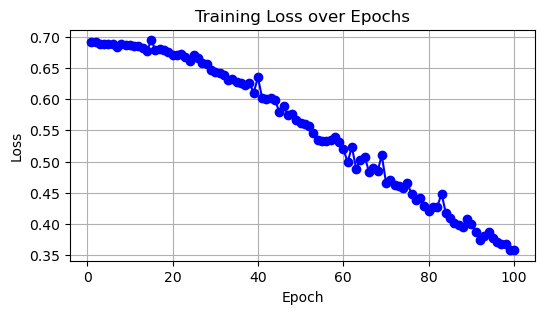

In [45]:
#Train the model
model=GCN() #define model
optimizer=torch.optim.Adam(model.parameters(),lr=0.01) #set up optimizer with a learning rate of 0.01
criterion=torch.nn.BCEWithLogitsLoss() #define loss function
train_loader=DataLoader(train_data,batch_size=8,shuffle=True) #batch size is the number of training example that the model will see before the gradients are updated

#training loop
def train():
    model.train()
    total_loss=0
    for data in train_loader:#load batches fom data loader
        optimizer.zero_grad() #reset gradients
        out=model(data)#pass batch through model to get predictions(forward pass)
        loss=criterion(out,data.y)#calculate loss between predictions and true labels
        loss.backward() #backpropagate the loss to compute gradients
        optimizer.step() #update the model parameters using the gradients
        total_loss+=loss.item() #accumulate batch loss into total loss
    return total_loss/len(train_loader) #return loss average per batch

#Train the model for 100 epochs
losses=[]
for epoch in range(100):
    loss=train()
    losses.append(loss)
    if epoch % 10==0:
        print(f'Epoch:{epoch},Loss:{loss:.4f}')
epochs=list(range(1,len(losses)+1))

#Visualize the loss values
plt.figure(figsize=(6,3))
plt.plot(epochs,losses,marker='o',linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
    


Next, we evaluate the model on the test set by calculating the accuracy of our predictions. We also compute a confusion matrix to see the amount of true positives, true negatives, false positives and false negatives.

In [49]:
test_loader=DataLoader(test_data,batch_size=8,shuffle=False)

model.eval()
actual_labels=[]
predicted_labels=[]

correct=0

for data in test_loader:
    out=model(data)
    pred=torch.sigmoid(out)>0.5 #apply sigmoid function to get binary predictions, everything above 0.5 indicate that the patient is schizophrenic
    correct +=(pred==data.y).sum().item() #compute how many predictions are correct regarding the test set
    actual_labels.extend(data.y.int().tolist())
    predicted_labels.extend(pred.tolist())

accuracy=correct/len(test_data)
print(f'Accuracy:{accuracy:.4f}')


Accuracy:0.8889


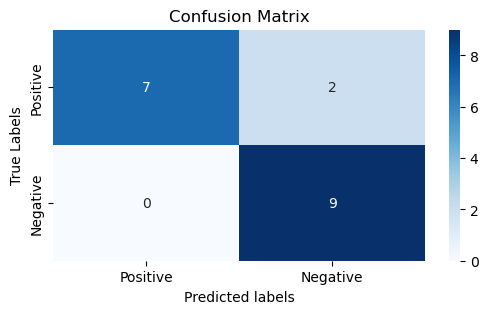

In [57]:
import seaborn as sns

true_positives=0
false_positives=0
true_negatives=0
false_negatives=0

for true,predicted in zip(actual_labels,predicted_labels):
    if predicted==1 and true==1:
        true_positives +=1
    elif predicted == 1 and true==0:
        false_positives +=1
    elif predicted==0 and true==0:
        true_negatives+=1
    elif predicted==0 and true==1:
        false_negatives+=1

conf_matrix=np.array([[true_positives,false_negatives],
                      [false_positives,true_negatives]])
#Define the labels for the confusion matrix
labels=["Positive","Negative"]
categories=["Positive","Negative"]

#Plotting the confusion matrix
plt.figure(figsize=(6,3))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True Labels")
plt.show()